## Объединение всех трех модальностей: финальный результат
Сейчас объединим эмбеддинги картинок и текстов, а также табличные данные. Начнем с обучения MLP на объединенных эмбеддингах

In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader

from utils.metrics import print_metrics
from utils.models import EmbeddingMLP
from utils.preprocess import preprocess_dataset
from utils.training import EmbeddingDataset, get_mlp_predictions, train_loop
import seaborn as sns
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda")

In [2]:
train = pd.read_parquet("data/train.parquet")
train["text"] = train["title"] + " " + train["description"]
train_X, train_y = preprocess_dataset(train)
train_X, val_X, train_y, val_y = train_test_split(
    train_X, train_y, random_state=42, test_size=0.1
)

train_inds = train_X.index
val_inds = val_X.index

In [ ]:
test = pd.read_parquet("data/test.parquet")
train["text"] = train["title"] + " " + train["description"]
test["text"] = test["title"] + " " + test["description"]
test_X, _ = preprocess_dataset(test, test=True)

In [3]:
text_embeddings = torch.tensor(np.load("data/train_embeddings_text.npy"))
img_embeddings = torch.load(
    "data/train_embeddings_large.pt", map_location="cpu"
)
merged_embeddings = torch.cat([img_embeddings, text_embeddings], dim=1)
train_embeddings = merged_embeddings[train_inds, :]
val_embeddings = merged_embeddings[val_inds, :]

embedding_dim = train_embeddings.shape[1]

In [4]:
train_dataset = EmbeddingDataset(train_embeddings, train_y)
val_dataset = EmbeddingDataset(val_embeddings, val_y)

train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=True)

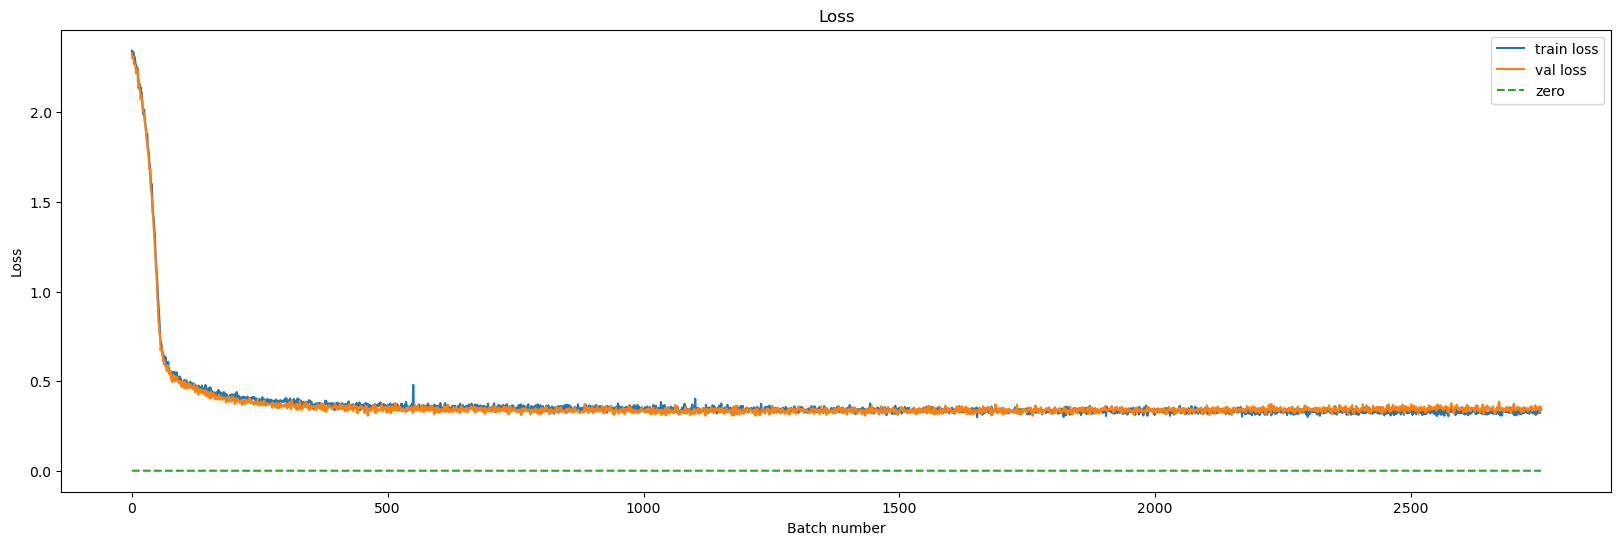

In [ ]:
lr = 0.0001
n_epochs = 5
loss_func = nn.L1Loss()

model = EmbeddingMLP(embedding_dim)
model = model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0001)

train_loop(
    n_epochs,
    loss_func,
    model,
    optimizer,
    train_dataloader,
    val_dataloader,
    DEVICE,
)

In [ ]:
torch.save(model.state_dict(), "models/img_text_fusion_mlp.pth")

In [9]:
model = EmbeddingMLP(embedding_dim).to(DEVICE)
model.load_state_dict(
    torch.load("models/img_text_fusion_mlp.pth", weights_only=True)
)

<All keys matched successfully>

In [10]:
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=False)
mlp_val_preds = get_mlp_predictions(model, val_dataloader, DEVICE)
print_metrics(val_y, mlp_val_preds)

log_real_weight:
	mae=0.2384
	r2=0.5720
	corr=0.7836
log_real_height:
	mae=0.4960
	r2=0.2703
	corr=0.5214
log_real_length:
	mae=0.3224
	r2=0.1939
	corr=0.5496
log_real_width:
	mae=0.3179
	r2=0.1771
	corr=0.5143
Mean MAE: 0.3437


Результат даже несколько хуже, чем просто на эмбеддингах картинок

## CatBoost: категории + ответы MLP на эмбеддингах
Воспользуемся результатом, полученном при анализе информативности картиночных эмбеддингов: обучим катбуст на ответах MLP, обуенных отдельно на картичночных и текстовых эмбеддингах, и табличных фичах.

In [6]:
from catboost import CatBoostRegressor, Pool

In [7]:
# загрузка полученных ранее ответах MLP
mlp_train_preds_text = np.load(
    "mlp_predictions/train_mlp_berta_predicitons.npy"
)
mlp_val_preds_text = np.load("mlp_predictions/val_mlp_berta_predicitons.npy")
mlp_test_preds_text = np.load("mlp_predictions/test_mlp_berta_predicitons.npy")

mlp_train_preds_img = np.load(
    "mlp_predictions/train_mlp_siglip_large_predicitons.npy"
)
mlp_val_preds_img = np.load(
    "mlp_predictions/val_mlp_siglip_large_predicitons.npy"
)
mlp_test_preds_img = np.load(
    "mlp_predictions/test_mlp_siglip_large_predicitons.npy"
)

In [ ]:
# объединение полученных предсказаний MLP и табличных признаков
train_X_w_preds = pd.concat(
    [
        train_X.reset_index(drop=True),
        pd.DataFrame(
            mlp_train_preds_img, columns=train_y.columns + "_preds_img"
        ),
        pd.DataFrame(
            mlp_train_preds_text, columns=train_y.columns + "_preds_text"
        ),
    ],
    axis=1,
)

val_X_w_preds = pd.concat(
    [
        val_X.reset_index(drop=True),
        pd.DataFrame(mlp_val_preds_img, columns=val_y.columns + "_preds_img"),
        pd.DataFrame(
            mlp_val_preds_text, columns=train_y.columns + "_preds_text"
        ),
    ],
    axis=1,
)

test_X_w_preds = pd.concat(
    [
        test_X.reset_index(drop=True),
        pd.DataFrame(mlp_test_preds_img, columns=val_y.columns + "_preds_img"),
        pd.DataFrame(
            mlp_test_preds_text, columns=val_y.columns + "_preds_text"
        ),
    ],
    axis=1,
)

In [14]:
categorical_cols = [
    "item_condition",
    "category_name",
    "subcategory_name",
    "microcat_name",
]

train_pool = Pool(train_X_w_preds, train_y, cat_features=categorical_cols)
val_pool = Pool(val_X_w_preds, val_y, cat_features=categorical_cols)

In [ ]:
cat = CatBoostRegressor(
    loss_function="MultiRMSE",
    od_wait=50,
    n_estimators=5000,
    task_type="GPU",
    use_best_model=True,
)
cat.fit(
    train_pool, eval_set=val_pool, metric_period=10, plot=False, verbose=True
)

In [16]:
cat_preds = cat.predict(val_X_w_preds)
print_metrics(val_y, cat_preds)

log_real_weight:
	mae=0.2293
	r2=0.6301
	corr=0.7938
log_real_height:
	mae=0.4991
	r2=0.2860
	corr=0.5348
log_real_length:
	mae=0.2711
	r2=0.3025
	corr=0.5500
log_real_width:
	mae=0.2823
	r2=0.2838
	corr=0.5328
Mean MAE: 0.3204


На данный момент получен наилучший результат. Все предыдущие попытки время CatBoost учился в режиме мультитаргетной регрессии, при этом использовалась лосс функция multiRMSE, которая не является целевой метрикой в задаче. Попробуем заменить ее на 4 отдельных модели, обучаемых на один из таргетов с помощью MAE, при этом будем подавать в каждую модель одинаковый набор признаков, включая предсказания MLP на эмбеддингах

In [ ]:
cats = {}
for col in train_y.columns:
    train_pool = Pool(
        train_X_w_preds, train_y[col], cat_features=categorical_cols
    )
    val_pool = Pool(val_X_w_preds, val_y[col], cat_features=categorical_cols)
    cat = CatBoostRegressor(
        loss_function="MAE",
        od_wait=50,
        n_estimators=5000,
        task_type="GPU",
        use_best_model=True,
    )
    cat.fit(
        train_pool,
        eval_set=val_pool,
        metric_period=10,
        plot=False,
        verbose=True,
    )
    cats[col] = cat

In [18]:
cat_preds = np.stack(
    [cats[col].predict(val_X_w_preds) for col in train_y.columns], axis=1
)
print_metrics(val_y, cat_preds)

log_real_weight:
	mae=0.2201
	r2=0.6198
	corr=0.7931
log_real_height:
	mae=0.4822
	r2=0.2473
	corr=0.5186
log_real_length:
	mae=0.2674
	r2=0.2952
	corr=0.5482
log_real_width:
	mae=0.2792
	r2=0.2789
	corr=0.5323
Mean MAE: 0.3122


Использование отдельных моделей для каждого таргета и обучение на MAE позволило еще поднять метрику качества

## Анализ ошибок
Проанализируем ошибки моделей. 

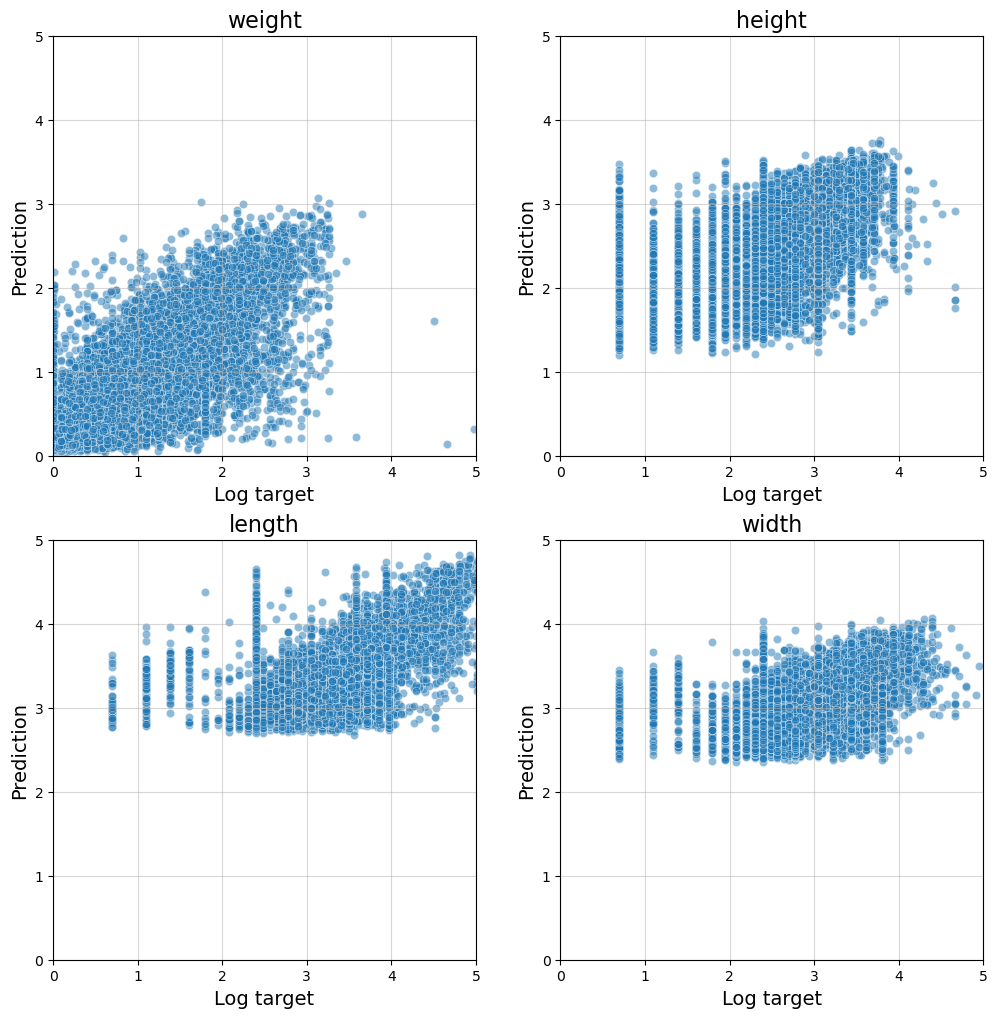

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
for ax, (i, col) in zip(axs.flatten(), enumerate(train_y.columns)):
    sns.scatterplot(x=val_y[col], y=cat_preds[:, i], ax=ax, alpha=0.5)
    ax.set_xlim((0, 5))
    ax.set_ylim((0, 5))
    ax.grid(alpha=0.5)
    ax.set_title(col.split("_")[-1], size=16)
    ax.set_xlabel("Log target", size=14)
    ax.set_ylabel("Prediction", size=14)

Проанализируем распределение логарифмированных значений таргетов

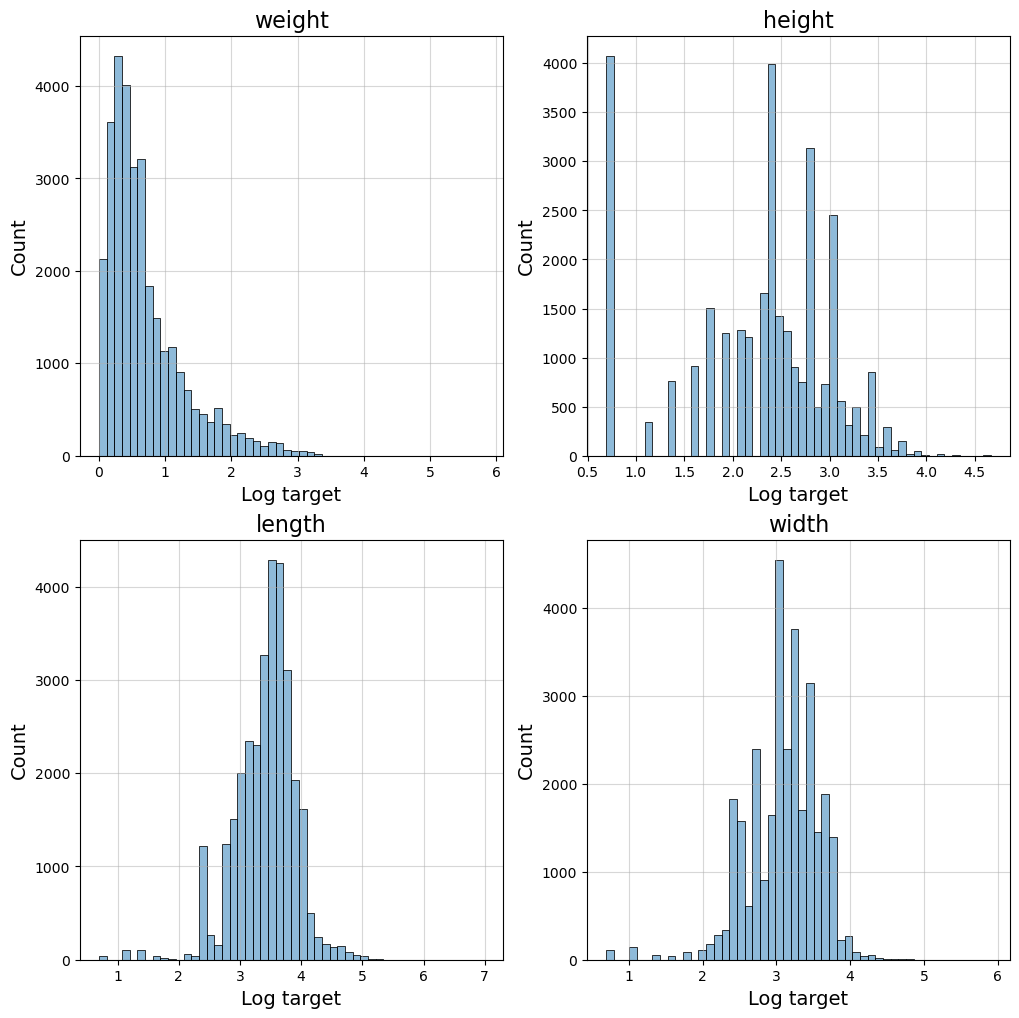

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
for ax, (i, col) in zip(axs.flatten(), enumerate(train_y.columns)):
    sns.histplot(x=val_y[col], ax=ax, alpha=0.5, bins=50)
    ax.grid(alpha=0.5)
    ax.set_title(col.split("_")[-1], size=16)
    ax.set_xlabel("Log target", size=14)
    ax.set_ylabel("Count", size=14)

In [33]:
train["real_height"].value_counts().iloc[:5]

real_height
1.0     40307
10.0    40168
15.0    25235
20.0    24659
9.0     16971
Name: count, dtype: int64

Видно, что низкие значение габаритных характеристик перепредсказываются. При этом наиболее они характерны для высоты - много значений, равных 1. Рассмотрим, каким категориям товаров они соответствуют

In [ ]:
train.loc[train["real_height"] == 1, "subcategory_name"].value_counts().iloc[
    :5
]

subcategory_name
Одежда, обувь, аксессуары    18633
Детская одежда и обувь        7940
Книги и журналы               2179
Красота и здоровье            2055
Запчасти и аксессуары         1930
Name: count, dtype: int64

In [ ]:
train.loc[train["real_height"] == 1, "microcat_name"].value_counts().iloc[:10]

microcat_name
Брюки                1852
Кофты и футболки     1564
Книги                1419
Джинсы               1378
Аксессуары           1313
Повседневные         1303
Пиджаки и костюмы    1200
Верхняя одежда        965
Парфюмерия            943
Кроссовки и кеды      925
Name: count, dtype: int64

Таким образом среди подобных товаров преобладают элементы, одежды: футболки, джинсы, брюки, т.е. предметы высота которых, видимо, часто не определена явным образом и принимается равной 1см.

## Выводы и дальнейшие направления работы
1. Использование всех трех типов данных оказалось полезным для решение задачи, решение с использованием эмбеддингов картинок, текстов и табличных данных показало самое лучшее качество.

2. При отдельном использовании наибольший вклад дают картинки, затем табличные данные включая категории, наименее информативные - текстовые данные. 
3. Наиболее эффективно показала себя постепенное включение данных в обучение - сначала 2 MLP обучаются отдельно на картиночных и тектосвых эмбеддингах в режиме мультитаргет регрессии, затем их предсказания объединяются с табличными признаками и используются для обучения CatBoost.
4. CatBoost  лучше себя показывает, когда обучается 4 отдельных моделей на целевую метрику - MAE, по сравнению с обучением одной модели с multiRMSE. 
5. Сильнее всего модели ошибаются на габаритных характеристиках для низких значений, особенно сильно выраженных для высоты.
6. Наиболее перспективное развитие - попытка устранить эти проблемы: использование весов для объектов и лоссов, сильнее штрафующих за передопредсказания. Я проводил точечные эксперименты с QuantileLoss, но они пока не дали позитивного результата.
7. При наличии более существенных вычислительных ресурсов интересное направление - дообучение CV модели (напр. EfficientNetV2) и текстового энкодера на таргетную задачу - предсказания характеристик. Возможно, использованные эмбеддинги не сохраняют достаточно информации про эти характеристики, и из исходных данных можно получить более релевантную информацию

In [36]:
cat_test_preds = np.stack(
    [cats[col].predict(test_X_w_preds) for col in train_y.columns], axis=1
)

In [ ]:
test_preds_orig = np.exp(cat_test_preds) - 1  # обратное рпеобразование
pd.concat(
    [
        test[["item_id"]],
        pd.DataFrame(
            test_preds_orig, columns=["weight", "height", "length", "width"]
        ),
    ],
    axis=1,
).to_csv("result_fusion_preds.csv", index=False)